In [1]:
import pandas as pd
df = pd.read_csv("F:/Anime/Transactions_Zomato/choti_file.csv")
df.head()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,86246,205,7,707,1078778070,12564,02-03-12,12.0,OZ,1,7.59
1,86246,205,63,6319,107654575,17876,02-03-12,64.0,OZ,1,1.59
2,86246,205,97,9753,1022027929,0,02-03-12,1.0,CT,1,5.99
3,86246,205,25,2509,107996777,31373,02-03-12,16.0,OZ,1,1.99
4,86246,205,55,5555,107684070,32094,02-03-12,16.0,OZ,2,10.38


In [2]:
df_defined = df.filter(['id','date','purchasequantity','purchaseamount'],axis=1)
df_defined.head()

,id,date,purchasequantity,purchaseamount
0,86246,02-03-12,1,7.59
1,86246,02-03-12,1,1.59
2,86246,02-03-12,1,5.99
3,86246,02-03-12,1,1.99
4,86246,02-03-12,2,10.38


In [3]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\tilak\AppData\Roaming\Python\Python36\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\tilak\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`

In [1]:
!c:\users\tilak\anaconda3\python.exe -m pip install --upgrade pip

Requirement already up-to-date: pip in c:\users\tilak\anaconda3\lib\site-packages (10.0.1)


In [2]:
!pip install lifetimes
    

  Running setup.py bdist_wheel for dill: started
  Running setup.py bdist_wheel for dill: finished with status 'done'
  Stored in directory: C:\Users\tilak\AppData\Local\pip\Cache\wheels\e2\5d\17\f87cb7751896ac629b435a8696f83ee75b11029f5d6f6bda72
Successfully built dill


In [5]:
import lifetimes
rfm = lifetimes.utils.summary_data_from_transaction_data(
     df_defined,
    'id',
    'date',
    observation_period_end=pd.to_datetime('19-01-13'),
    freq='W'
)
rfm.head()

,frequency,recency,T
id,,,
86246,50.0,54.0,54.0
12262064,47.0,54.0,54.0
12277270,46.0,54.0,54.0
13074629,41.0,54.0,54.0
13251776,46.0,53.0,53.0


In [8]:
from pymc3.math import exp, log

class ParetoNBD(pm.Continuous):
    """
    Custom distribution class for Pareto/NBD likelihood.
    """
    
    def __init__(self, lambda_, mu, *args, **kwargs):
        super(ParetoNBD, self).__init__(*args, **kwargs)
        self.lambda_ = lambda_
        self.mu = mu
        
    def logp(self, x, t_x, T):
        """
        Loglikelihood function for and indvidual customer's purchasing rate \lambda
        and lifetime \mu given their frequency, recency and time since first purchase.
        """
        
        log_lambda = log(self.lambda_)
        log_mu = log(self.mu)
        mu_plus_lambda = self.lambda_ + self.mu
        log_mu_plus_lambda = log(mu_plus_lambda)
        
        p_1 = x * log_lambda + log_mu - log_mu_plus_lambda - t_x * mu_plus_lambda
        p_2 = (x + 1) * log_lambda - log_mu_plus_lambda - T * mu_plus_lambda
        
        return log(exp(p_1) + exp(p_2))


In [10]:
N = rfm.shape[0] # number of customers
x = rfm['frequency'].values
t_x = rfm['recency'].values
T = rfm['T'].values # length of training peri
n_draws = 200

pnbd_model = pm.Model()

with pnbd_model:
    
    # Uninformative priors on model hyperparameters see Polson and Scott 
    # https://projecteuclid.org/download/pdfview_1/euclid.ba/1354024466
    r = pm.HalfCauchy('r', beta=2)
    alpha = pm.HalfCauchy('alpha', beta=2)
    s = pm.HalfCauchy('s', beta=2)
    beta = pm.HalfCauchy('beta', beta=2)
    
    # Gamma prior on purchasing rate parameter lambda
    lambda_ = pm.Gamma('lambda', alpha=r, beta=alpha, shape=N, testval=np.random.rand(N))
    # Gamma prior on lifetime parameter mu
    mu = pm.Gamma('mu', alpha=s, beta=beta, shape=N, testval=np.random.rand(N))

    # Custom distribution for Pareto-NBD likelihood function
    loglikelihood = ParetoNBD("loglikelihood", mu=mu, lambda_=lambda_, observed={'x': x, 't_x': t_x, 'T': T})
    
    # Sample the model
    trace = pm.sample(n_draws, init=None,njobs=1)


Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [mu_log__, lambda_log__, beta_log__, s_log__, alpha_log__, r_log__]
100%|████████████████████████████████████████| 700/700 [43:18<00:00,  3.71s/it]
C:\Users\tilak\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
C:\Users\tilak\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept`

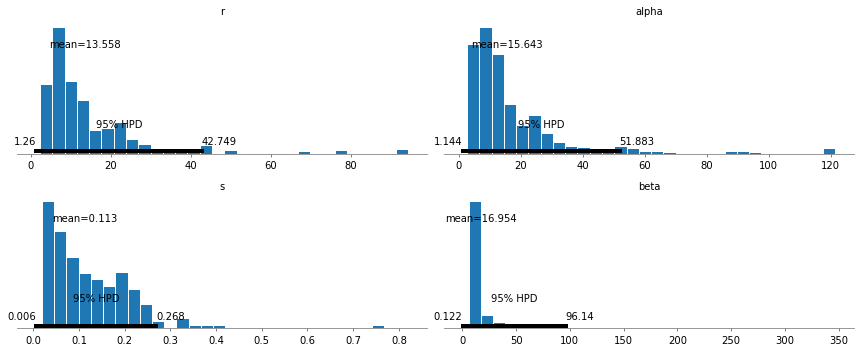

In [22]:

_  =  pm.plot_posterior(trace, varnames=['r','alpha','s', 'beta'])

In [23]:
from pymc3.math import exp, log

class ParetoNBD(pm.Continuous):
    """
    Custom distribution class for Pareto/NBD likelihood.
    """
    
    def __init__(self, lambda_, mu, *args, **kwargs):
        super(ParetoNBD, self).__init__(*args, **kwargs)
        self.lambda_ = lambda_
        self.mu = mu
        
    def logp(self, x, t_x, T):
        """
        Loglikelihood function for and indvidual customer's purchasing rate \lambda
        and lifetime \mu given their frequency, recency and time since first purchase.
        """
        
        log_lambda = log(self.lambda_)
        log_mu = log(self.mu)
        mu_plus_lambda = self.lambda_ + self.mu
        log_mu_plus_lambda = log(mu_plus_lambda)
        
        p_1 = x * log_lambda + log_mu - log_mu_plus_lambda - t_x * mu_plus_lambda
        p_2 = (x + 1) * log_lambda - log_mu_plus_lambda - T * mu_plus_lambda
        
        return log(exp(p_1) + exp(p_2))


In [24]:
def prob_alive_at_T(lambda_, mu, t_x, T):
    """
    Probability a customer's time of death \tau occurs after T.
    
    Pr(\tau > T \> | \> \lambda, \mu, x, t_x,T) = \dfrac{1}{1+\dfrac{\mu}{\mu+\lambda}
    \big\{e^{(\lambda+\mu)(T-t_x)}-1\big\}}
    
    See expression (7) in technical appendix of Abe.
    
    :param lambda_: lambda parameter at the customer level :
    :type lambda_: scalar
    :param mu: mu parameter at the customer level
    :type mu_: scalar
    :param t_x: recency of transactions
    :type t_x: float
    :param T: duration of the calibration/training period
    :type T: float
    
    :return: probability of being alive at time T.
    """

    den = 1 + (mu / (lambda_ + mu)) * (np.exp((lambda_ + mu) * (T - t_x)) - 1)
    return 1 / den

In [25]:
def likelihood(lambda_, mu, x, t, T):
    """Pareto/NBD likelihood function.

    :param lambda_: lambda parameter at the customer-level.
    :param mu: mu parameter at the customer level
    :param x: number of repeat transactions
    :param t: recency
    :param T: length of the calibration/training period.

    :return: likelihood value.
    """

    p1 = x * np.log(lambda_) + np.log(mu) - np.log(mu + lambda_) - t * (mu + lambda_)
    p2 = (x + 1) * np.log(lambda_) - np.log(mu + lambda_) - T * (mu + lambda_)
    return np.exp(p1) + np.exp(p2)

def predict(t, lambda_, mu, x, tx, T):
    """Conditional expected purchases at end of time (T, T+t).

    Used to assess holdout period performance and to make predictions
    for future time period t. Conditional on purchase history (x, t_x, T).

    E[X(T,T+t) \> | \> \lambda, \mu, x, t_x, T] = \dfrac{1}{L(\lambda, \mu)|(x, t_x, T)}
    \times \dfrac{\lambda^{x+1}}{\mu}e^{-(\lambda+\mu)T}(1-e^{-\mu t})

    http://brucehardie.com/notes/034/corr_Pareto-NBD.pdf

    :param t: time period
    :type t: scalar

    :param lambda_: lambda parameter at the customer level :
    :type lambda_: scalar

    :param mu: mu parameter at the customer level
    :type mu_: scalar

    :param x: number of repeat transactions
    :type x: integer

    :param tx: recency of transactions
    :type tx: float

    :param T: duration of the calibration/training period
    :type T: float

    :return expected number of purchases (scalar)
    """
    like = likelihood(lambda_, mu, x, tx, T)
    p2 = lambda_ ** (x + 1) / mu * np.exp(-(lambda_ + mu) * T) * (1 - np.exp(-mu * t))

    return 1 / like * p2

In [93]:
from lifetimes.utils import calibration_and_holdout_data

rfm = calibration_and_holdout_data(
    df_defined, 
    customer_id_col='id',
    datetime_col='date',
    calibration_period_end='19-06-12',
    observation_period_end='22-01-13',
    freq='W'
)

rfm.describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
count,5.00000,5.000000,5.000000,5.000000,5.0
mean,18.20000,23.600000,23.800000,29.200000,31.0
std,1.30384,0.547723,0.447214,2.774887,0.0
min,17.00000,23.000000,23.000000,25.000000,31.0
25%,17.00000,23.000000,24.000000,28.000000,31.0
50%,18.00000,24.000000,24.000000,30.000000,31.0
75%,19.00000,24.000000,24.000000,31.000000,31.0
max,20.00000,24.000000,24.000000,32.000000,31.0


In [107]:
customer_index = 2
# show purchasing behavior
rfm.iloc[customer_index]

frequency_cal          19.000000
recency_cal            24.000000
T_cal                  24.000000
frequency_holdout      28.000000
duration_holdout       31.000000
frequency_predicted    27.371843
Name: 12277270, dtype: float64

In [117]:
lambda_post = trace['lambda']
mu_post = trace['mu']

# Select distributions of lambda and mu for a customer
lambda_individual = lambda_post[:,customer_index]
mu_individual = mu_post[:,customer_index]

# predict purchases for the user at t = 39
t = 2
predict(t, lambda_individual, mu_individual, x[customer_index], t_x[customer_index], T[customer_index]).mean()

1.3618172132945319

In [110]:
t = 40
# predictions are size of customer base x number of draws
holdout_predictions = np.empty([N, 400])

for i in np.arange(N):
    holdout_predictions[i] = predict(
        t, 
        lambda_post[:,i], 
        mu_post[:,i], 
        x[i], 
        t_x[i], 
        T[i]
    )

# predictions are posterior mean
rfm['frequency_predicted'] = holdout_predictions.mean(axis=1)
rfm[['frequency_holdout','frequency_predicted']].sum()

frequency_holdout      146.000000
frequency_predicted    143.644869
dtype: float64

In [111]:
rfm[['frequency_holdout','frequency_predicted']].sum()

frequency_holdout      146.000000
frequency_predicted    143.644869
dtype: float64

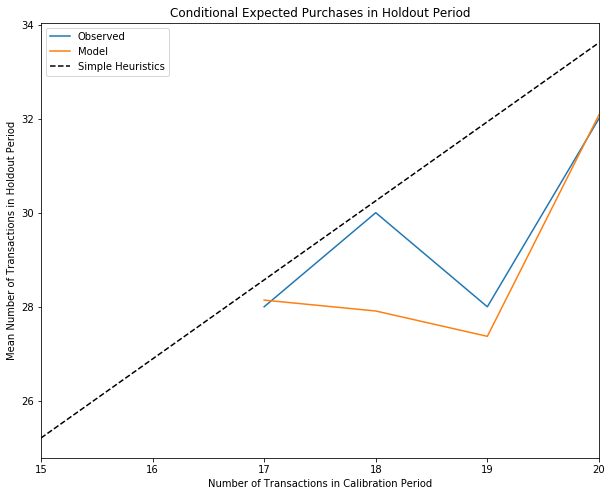

In [112]:
xlim=(15,20)
mean_frequencies = rfm.groupby('frequency_cal')[['frequency_holdout',
                                     'frequency_predicted']].mean()
mean_frequencies.rename(columns={'frequency_holdout': 'Observed',
                                 'frequency_predicted': 'Model'},
                        inplace=True)
mean_frequencies.plot(kind='line',
                      title='Conditional Expected Purchases in Holdout Period', figsize=(10, 8))

# Generate a dummy model with holdout freq = t_holdout/t_calib
t_calib = np.mean(rfm['T_cal'])
t_holdout = t
x_heuristics = np.linspace(xlim[0],xlim[1],100)
heuristics = t_holdout/t_calib * x_heuristics

plt.plot(x_heuristics, heuristics, linestyle='--', color='black', label='Simple Heuristics')
plt.legend(loc=0)
plt.xlim(xlim)
plt.ylabel('Mean Number of Transactions in Holdout Period')
plt.xlabel('Number of Transactions in Calibration Period')
plt.grid(False)
plt.show()